In [1]:
import numpy as np

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from network import Network
from mcts import RandomMCTS, GreedyMCTS


In [2]:
# functions of Google OR-Tools, for optimal solution

def create_data_model(network):
    """Stores the data for the problem."""
    num_of_node = len(network.graph.nodes)
    
    data = {}
    data['distance_matrix'] = []
    
    for i in range(num_of_node):
        temp = [network.graph[i][j]['weight'] for j in range(num_of_node) if j!= i]
        temp.insert(i, 0.0)
        data['distance_matrix'].append(temp)

    data['num_vehicles'] = 1
    data['depot'] = 0
    return data


def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Objective: {} miles'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}miles\n'.format(route_distance)
    

In [4]:
np.random.seed(2020)

num_of_node = 10
side_length = 100
prob_greedy = 0.2

num_of_sample = 200
list_num_simulation = np.array([1,2,5,10,15,20,30,40,50,75,100,200,300])

mcts_random_prop = []
mcts_greedy_prop = []

for num_simulation in list_num_simulation:
    mcts_random_cost = []
    mcts_greedy_cost = []
    optimal_cost = []

    for i in tqdm(range(num_of_sample)):
        ### random sample of a TSP
        network = Network(num_of_node, side_length)

        ### mcts 1 - random
        random_mcts = RandomMCTS(network)
        edges, cost = random_mcts.run(50, num_simulation, 1000)   # takes (number to expand, number to simulate, and constant C)
        mcts_random_cost.append(cost)

        ### mcts 2 - greedy
        greedy_mcts = GreedyMCTS(network, prob_greedy)
        edges, cost = greedy_mcts.run(50, num_simulation, 1000)
        mcts_greedy_cost.append(cost)

        ### optimal solution by Google OR-Tools
        data = create_data_model(network)
        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)
        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)
        optimal_cost.append(solution.ObjectiveValue())

    mcts_random_cost = np.array(mcts_random_cost)
    mcts_greedy_cost = np.array(mcts_greedy_cost)
    optimal_cost = np.array(optimal_cost)
    
    mcts_random_prop.append(sum(mcts_random_cost < 1.1*optimal_cost)/num_of_sample)
    mcts_greedy_prop.append(sum(mcts_greedy_cost < 1.1*optimal_cost)/num_of_sample)
    
    print(num_simulation)
    print(sum(mcts_random_cost < 1.1*optimal_cost)/num_of_sample)
    print(sum(mcts_greedy_cost < 1.1*optimal_cost)/num_of_sample)


  1%|          | 2/200 [00:00<00:25,  7.89it/s]

1
0.425
0.54


  2%|▏         | 4/200 [00:00<00:13, 14.27it/s]

2
0.63
0.675


  2%|▏         | 3/200 [00:00<00:19, 10.23it/s]

5
0.62
0.72


  0%|          | 1/200 [00:00<00:33,  5.95it/s]

10
0.685
0.82


  0%|          | 0/200 [00:00<?, ?it/s]

15
0.69
0.76


  0%|          | 0/200 [00:00<?, ?it/s]

20
0.775
0.8


  0%|          | 0/200 [00:00<?, ?it/s]

30
0.795
0.83


  0%|          | 0/200 [00:00<?, ?it/s]

40
0.78
0.81


  0%|          | 0/200 [00:00<?, ?it/s]

50
0.79
0.83


  0%|          | 0/200 [00:00<?, ?it/s]

100
0.795
0.91


  0%|          | 0/200 [00:00<?, ?it/s]

200
0.785
0.935


100%|██████████| 200/200 [07:36<00:00,  2.28s/it]

300
0.84
0.92


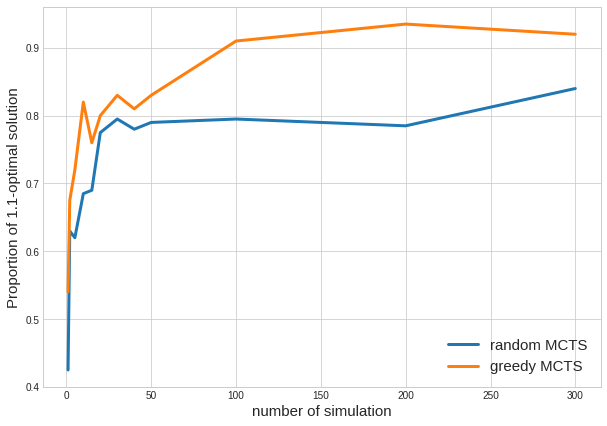

In [5]:
f = plt.figure(figsize = (10,7))
plt.plot(list_num_simulation, mcts_random_prop, linewidth=3, label="random MCTS")
plt.plot(list_num_simulation, mcts_greedy_prop, linewidth=3, label="greedy MCTS")
plt.xlabel('number of simulation', size=15)
plt.ylabel('Proportion of 1.1-optimal solution', size=15)
plt.legend(loc='lower right', fontsize=15)